In [4]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io

In [26]:
def get_data(filename, ndata, r):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29 - basically r selects the course-grainedness, r=1 means no course-graining
    r = r
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = scipy.io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x, y

r = 5
s = int(((421 - 1) / r) + 1)

x_train, y_train = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth1.mat", 1000, r)
x_test, y_test = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth2.mat", 200, r)

Visualise training data. Mapping from permeability field `x` $ = K(x, y)$ to a pressure field `y` $ = h(x,y)$, both defined on the domain $[0,1]^2$

2 (1000, 7225) (7225, 2) (1000, 7225)
2 (200, 7225) (7225, 2) (200, 7225)


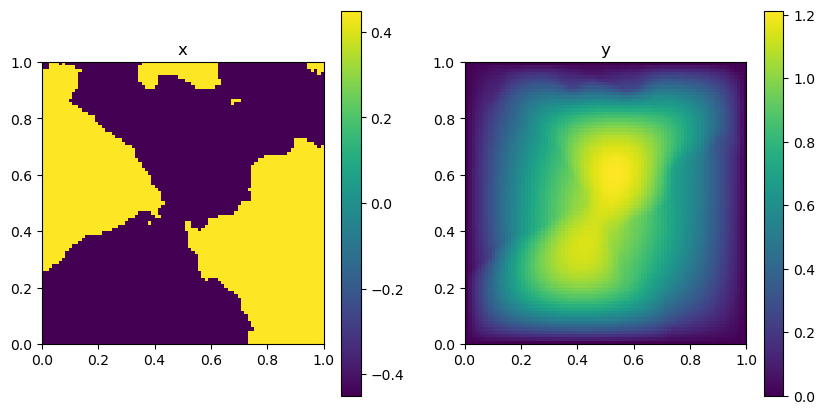

In [31]:
index_to_plot = 127

print(len(x_train), x_train[0].shape, x_train[1].shape, y_train.shape)
print(len(x_test), x_test[0].shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[0][index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("y")
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()